In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import nltk
from collections import OrderedDict
import pickle
%matplotlib inline

In [2]:
risk_qa = pd.read_excel("risk_data.xlsx")

In [3]:
risk_qa.head()

,客戶編號,風險等級,風險等級分類,適性評量填寫日期,適性版號,題目序號,KYC_QUESTION,ANS_ORDER,ANS_ITEM,答題得分,客戶職業與任職部門,AGENT代碼
0,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A0,是否為其他國家稅務居住者?,1,1.否,0,NaN,9999999999
1,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A01,職業／行業別,8,8.退休人士,0,NaN,9999999999
2,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A02,職務,1,1.基層職員,0,NaN,9999999999
3,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A03,任職單位,1,1.任職公司／機構,0,寶豐,9999999999
4,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A03,任職單位,2,2.任職部門,0,營建,9999999999


In [4]:
uni_id = np.unique(risk_qa["客戶編號"])

In [5]:
attr_dict = defaultdict(lambda: defaultdict(list))
max_ans_dict = defaultdict(int) # record max answer num for each question (for one-hot array)

for index, row in risk_qa.iterrows():
    attr_dict[row["客戶編號"]][row["題目序號"]].append(row["ANS_ORDER"])
    if max_ans_dict[row["題目序號"]]<row["ANS_ORDER"]:
        max_ans_dict[row["題目序號"]] = row["ANS_ORDER"]


In [6]:
# filter out duplicate
for k1 in attr_dict.keys():
    for k2 in attr_dict[k1].keys():
        attr_dict[k1][k2] = list(set(attr_dict[k1][k2]))

In [8]:
# 問卷答案的字典
attr_dict[261909]

defaultdict(list,
            {'A0': [1],
             'A01': [8],
             'A02': [1],
             'A03': [1, 2],
             'A04': [4],
             'A05': [3],
             'A06': [1],
             'A07': [1],
             'A08': [1, 3, 5],
             'A09': [2, 3],
             'A10': [2],
             'A11': [1],
             'A12': [1],
             'A13': [1],
             'A14': [4],
             'B01': [3],
             'B02': [1, 2, 3, 4, 5],
             'B03': [3, 4, 5],
             'B04': [5],
             'B05': [4],
             'B06': [4],
             'B07': [4]})

#### 每個答案做成一個字 ， 每個 user 當一篇文章，計算答案的共現性


In [9]:
doc_word_list = []
for uid in attr_dict.keys():
    single_word_list = []
    for aid in attr_dict[uid].keys():
        single_word_list += [aid + "_" + str(ans) for ans in attr_dict[uid][aid]]
    doc_word_list.append(single_word_list)

In [10]:
names = list(set([w for l in doc_word_list for w in l]))
occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
 
# Find the co-occurrences:
for l in doc_word_list:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1
            
co_occur = pd.DataFrame.from_dict(occurrences)

In [11]:
# co_occur.to_csv('./answer_cooccurance_matrix.csv')

### query and ranking 

In [12]:
query = "A01_2"
print("Ranking")
co_occur[query].sort_values(ascending=False)[:10]

Ranking


A0_1     119
A07_1    119
A03_1    119
A03_2    119
A14_4    118
A06_1    115
A09_1    112
B02_1    109
B03_4    108
A13_1    107
Name: A01_2, dtype: int64

### t-testing

In [128]:
np.unique(total_words, return_counts=True)

array([ 220,    3,   27,   38,   26,   16,    4,    1,  119,    4,  177,
         30,   17,   69,  178,  309,  265,   99,   73,  208,   11,  545,
        375,  150,  292,  101,   73,  356, 1884, 1884,   51,  192,  362,
        836,  443,  434, 1067,  387, 1746,   37,   16,    5,    4,   81,
       1882, 1235,  151,  941,  362, 1263,  150,    5, 1409,  304, 1064,
        131,   18,   25,  126,  119,   20, 1882,    3,  192,  589,  939,
        141,   36,  713,  861,  300,   15,    8, 1468,  318,  106, 1695,
        194,   34,   22,   20, 1806,   40,   85,  322,  709,  729, 1625,
        886, 1164, 1567, 1210,  285,  494,  871, 1535, 1315,   21,  171,
        469,  254,  982,    4,    6,  734, 1099,   51,   10,  154,  487,
        590,  656,   87,  232,  376,  445,  758], dtype=int64)

In [13]:
total_words = [word for doc in doc_word_list for word in doc]
total_words_count = len(total_words)
words_p_dict = {}
uniq = np.unique(total_words, return_counts=True)
for word, count in zip(uniq[0], uniq[1]):
    words_p_dict[word] = count/total_words_count
    
co_occur_prob = co_occur/total_words_count

In [14]:
t_test_dict = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
significant_dict = defaultdict(list)
for name1 in names:
    for name2 in names:
        u = words_p_dict[name1]*words_p_dict[name2]
        if name1 == name2:
            x_bar = 1
        else:
            x_bar = co_occur_prob[name1][name2]
        if x_bar == 0.:
            value = 0
        else: 
            value = (x_bar-u)/(x_bar/total_words_count)**0.5
        t_test_dict[name1][name2] = value
        if value> 2.576:
            significant_dict[name1].append(name2)

t_test = pd.DataFrame.from_dict(t_test_dict)

In [17]:
print(significant_dict["A01_1"])

['B02_4', 'B07_4', 'A02_3', 'B06_5', 'B03_5', 'A02_4', 'A11_3', 'B07_2', 'A03_2', 'A05_3', 'A09_7', 'B07_3', 'A01_1', 'A05_1', 'A06_1', 'A14_4', 'A08_5', 'A0_1', 'A10_4', 'A02_2', 'B03_3', 'B05_3', 'A09_4', 'B07_5', 'A04_4', 'A02_5', 'A12_1', 'A04_3', 'A08_2', 'B06_4', 'B03_2', 'A04_5', 'A08_3', 'A11_1', 'A05_2', 'B03_4', 'B04_5', 'B06_2', 'B01_5', 'A13_1', 'A13_2', 'B04_3', 'A10_2', 'B01_3', 'B04_2', 'B02_2', 'B02_5', 'A08_4', 'A11_2', 'B03_1', 'A09_3', 'B02_1', 'B07_1', 'A10_3', 'A12_3', 'A07_1', 'A09_1', 'B01_4', 'B06_3', 'A02_1', 'A03_1', 'A12_2', 'B04_4', 'B05_4', 'B02_3', 'A08_1', 'A08_6']


In [18]:
t_test["A01_2"].sort_values(ascending=False)[:10]

A01_2    232.775594
A0_1      10.529821
A07_1     10.529821
A03_1     10.529419
A03_2     10.529419
A14_4     10.497653
A06_1     10.366234
A09_1     10.290610
B02_1     10.098478
B03_4     10.067917
Name: A01_2, dtype: float64

In [19]:
# t_test.to_csv('./t_test.csv')

In [20]:
# create feature matrix

In [21]:
question_list = list(max_ans_dict.keys())
print(question_list)

['A0', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07']


In [22]:
print(max_ans_dict)

defaultdict(<class 'int'>, {'A0': 3, 'A01': 24, 'A02': 7, 'A03': 2, 'A04': 5, 'A05': 3, 'A06': 6, 'A07': 1, 'A08': 7, 'A09': 9, 'A10': 5, 'A11': 5, 'A12': 3, 'A13': 2, 'A14': 4, 'B01': 5, 'B02': 5, 'B03': 5, 'B04': 5, 'B05': 5, 'B06': 5, 'B07': 5})


In [23]:
# pickle.dump(max_ans_dict, open("./max_ans_dict.pkl","wb"))

## create feature matrix (one-hot encoding)

In [24]:
feature_matrix = []
id_list = []
uid_feature_dict = defaultdict()
for user in attr_dict.keys():
    single_user_feature = []
    for q in question_list:
        ans = np.array(attr_dict[user][q])-1
        one_hot = np.zeros(max_ans_dict[q])
        if len(ans)!=0:
            one_hot[ans] = 1
        single_user_feature.append(one_hot)
    merge_feature = np.hstack(single_user_feature)
    feature_matrix.append(merge_feature)
    id_list.append(user)
    uid_feature_dict[user] = merge_feature
feature_matrix = np.vstack(feature_matrix)

In [25]:
# question answer indexing
user_id = 159728
q_id = "B02"
q_index = list(max_ans_dict.keys()).index(q_id)
start_index = sum(list(max_ans_dict.values())[:q_index])
end_index = start_index+max_ans_dict[q_id]
print(uid_feature_dict[user_id][start_index:end_index])

[ 1.  1.  1.  1.  1.]


In [26]:
pickle.dump(uid_feature_dict, open("./uid_feature_dict.pkl","wb"))

In [27]:
# 客戶之風險等級
risk_dist = risk_qa[["客戶編號","風險等級"]].drop_duplicates()["風險等級"]

np.unique(risk_dist, return_counts=True)

(array([2, 4, 5], dtype=int64), array([   2,  101, 1786], dtype=int64))

非常多數的使用者問卷答案都偏好風險五

In [28]:
feature_matrix.shape

(1884, 121)

In [29]:
# X = feature_matrix
# X_embedded = TSNE(n_components=2, perplexity=80).fit_transform(X)
# X_embedded = PCA(n_components=2).fit_transform(X)

# X_embedded.shape

# plt.figure(figsize=(16,9))
# # cm = plt.cm.get_cmap("tab20", 18)
# sc = plt.scatter(X_embedded[:,0], X_embedded[:,1])
# plt.show()

# 實際投資行為

In [30]:
invest = pd.read_excel("invest_data.xlsx")

In [31]:
user_invest_dict = defaultdict(list)
for index, row in invest.iterrows():
    uid = row["客戶"]
    fund = row["基金簡稱"].replace("-","").replace(" ","")
    user_invest_dict[uid].append(fund)

In [32]:
len(user_invest_dict.keys())

1522

In [33]:
len(attr_dict.keys())

1884

### combine fund name with answers word

In [35]:
doc_word_list = []
for uid in user_invest_dict.keys():
    single_word_list = []
    for aid in attr_dict[uid].keys():
        single_word_list += [aid + "_" + str(ans) for ans in attr_dict[uid][aid]]
    single_word_list += user_invest_dict[uid]
    doc_word_list.append(single_word_list)

In [36]:
# compute co-occurrence matrix
names = list(set([w for l in doc_word_list for w in l]))
occurrences_w_fund = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
 
# Find the co-occurrences:
for l in doc_word_list:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences_w_fund[l[i]][item] += 1
            
co_occur_w_fund = pd.DataFrame.from_dict(occurrences_w_fund)

In [37]:
co_occur_w_fund.head()

,A01_19,野村新興收益傘型基金之中國境內新興債券基金人民幣計價,野村四年階梯到期新興債累積新臺幣計價,A02_6,A09_6,A09_8,A09_5,野村亞太新興債券基金配息類型新臺幣計價,A01_18,野村全球金融收益基金月配類型人民幣計價,...,A08_1,A01_7,野村全球美元投資級公司債基金累積型,野村全球高股息基金季配型新臺幣計價,野村新興收益傘型之五年階梯到期新興債基金累積美元,A08_6,野村鑫全球債券組合基金S類型,野村美利堅高收益債證券投資信託基金累積型新臺幣計價,野村平衡基金,野村新興收益傘型之五年階梯到期新興債基金季配人民幣
A01_1,0,0,2,0,0,4,2,3,0,0,...,123,0,0,0,0,12,0,3,1,0
A01_10,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
A01_12,0,0,0,1,0,2,0,0,0,0,...,12,0,0,0,0,1,0,0,0,0
A01_13,0,0,0,5,0,3,1,0,0,0,...,15,0,0,0,0,4,0,1,0,0
A01_14,0,0,0,2,0,6,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0


# ranking result of investment preference

In [65]:
query = "A01_2"
sorted_series = co_occur_w_fund[query].sort_values(ascending=False)

# find out the trend of investment
ranked_words_list = list(sorted_series.index)
ranked_occurrence_list = list(sorted_series.values)
ranked_fund = [(s,v) for s,v in zip(ranked_words_list, ranked_occurrence_list) if s[0]!="A" and s[0]!="B" and v!=0]
print("query:", query)
print("Ranking")
ranked_fund[:10]

query: A01_2
Ranking


[('野村新興傘型之大俄羅斯基金', 27),
 ('野村中國機會基金', 24),
 ('野村環球基金新臺幣計價', 23),
 ('野村泰國基金', 22),
 ('野村中小基金累積類型', 22),
 ('野村全球生技醫療基金', 22),
 ('野村台灣運籌基金', 17),
 ('野村雙印傘型之印度潛力基金', 16),
 ('野村巴西證券投資信託基金', 15),
 ('野村全球品牌基金', 12)]

In [67]:
query = "野村新興傘型之大俄羅斯基金"

sorted_series = co_occur_w_fund[query].sort_values(ascending=False)

# find out the trend of investment
ranked_words_list = list(sorted_series.index)
ranked_occurrence_list = list(sorted_series.values)
ranked_fund = [(s,v) for s,v in zip(ranked_words_list, ranked_occurrence_list) if v!=0 and s[0]!="A"]
print("query:",query)
print("Ranking")
ranked_fund[:10]

query: 野村新興傘型之大俄羅斯基金
Ranking


[('B02_4', 295),
 ('B03_5', 288),
 ('B02_1', 287),
 ('B03_4', 286),
 ('B02_5', 272),
 ('B05_4', 235),
 ('B02_3', 217),
 ('B04_5', 203),
 ('B07_5', 182),
 ('B02_2', 174)]

數量與原本的 co_occur 有出入是因為扣掉沒有實際投資資料的使用者

# Investment EDA

In [39]:
invest["weight"] = invest["風險等級"].apply(lambda x:int(x[-1]))
invest["weight_amount"] = invest["weight"]*invest["金額"]

In [40]:
customer = list(set(invest["客戶"]))
customer_count = invest.groupby('客戶',as_index=False, sort=False).count()
customer_total = invest.groupby('客戶',as_index=False, sort=False).sum()
customer_total.head()

,客戶,金額,weight,weight_amount
0,100066,601432,57,2261432
1,100542,3000,4,12000
2,100558,12000,18,57000
3,100606,12000,17,51000
4,100657,5000,4,20000


In [41]:
customer_total["weight_level"] = customer_total["weight_amount"]/customer_total["金額"]

In [42]:
customer_total.head()

,客戶,金額,weight,weight_amount,weight_level
0,100066,601432,57,2261432,3.760079
1,100542,3000,4,12000,4.000000
2,100558,12000,18,57000,4.750000
3,100606,12000,17,51000,4.250000
4,100657,5000,4,20000,4.000000


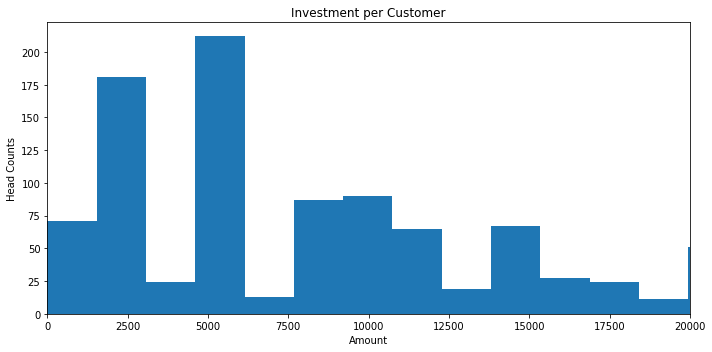

In [47]:
plt.figure(figsize=(10,5))
plt.hist(customer_total["金額"], bins=3000)
plt.xlim(0,20000)
plt.title("Investment per Customer")
plt.ylabel("Head Counts")
plt.xlabel("Amount")
plt.tight_layout()
plt.savefig('Investment per Customer small small.png', dpi=500)
plt.show()

In [61]:
len(np.unique(customer_total["客戶"]))

1522

In [49]:
sum(customer_total["金額"]<1000000)

1487

In [55]:
sum((customer_total["金額"]>1000000) * (customer_total["金額"]<3000000))

C:\Users\tsunh\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


33

In [56]:
sum(customer_total["金額"]>3000000)

2

In [27]:
np.unique(invest["風險等級"], return_counts=True)

(array(['RR1', 'RR2', 'RR3', 'RR4', 'RR5'], dtype=object),
 array([  61,   99,  521, 2609, 2530], dtype=int64))

In [ ]:
vis_vec = []
amount = []
risk_level = []
for c in customer:
    money = customer_total.loc[customer_total["客戶"]==c, "金額"].values[0]
    level = customer_total.loc[customer_total["客戶"]==c, "weight_level"].values[0]
    if money<100000:
        vis_vec.append(X_embedded[id_list.index(c)])
        amount.append(money)
        risk_level.append(level)
vis_vec = np.vstack(vis_vec)

In [ ]:
plt.hist(risk_level,bins=40)
plt.title("weighted risk level")
plt.show()

In [ ]:
amount = (np.array(amount)-min(amount))/(max(amount)-min(amount))

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(16,9))
points = ax.scatter(vis_vec[:,0], vis_vec[:,1], c=risk_level, s=50, cmap=cmap)
f.colorbar(points)
plt.title("risk level")
plt.show()

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(16,9))
points = ax.scatter(vis_vec[:,0], vis_vec[:,1], c=amount, s=50, cmap=cmap)
f.colorbar(points)
plt.title("investment amount")
plt.show()

# 產品名稱

In [ ]:
product_corpus = "".join(list(invest["基金簡稱"]))

In [ ]:
jieba.set_dictionary('C:/Users/thtang/Desktop/dict.txt.big.txt')

In [ ]:
product_words = jieba.lcut(product_corpus)

In [ ]:
" ".join(product_words).replace("基金","").replace("野村","")

In [ ]:
freq = nltk.FreqDist(product_words)

In [ ]:
freq.most_common()